# Variational Autoencoder
- MNIST dataset
- Variational Inference
- [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)

## 1. Settings
### 1) Import required libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

### 2) Set hyperparameters

In [2]:
batch_size = 128
learning_rate = 0.0005
num_epoch = 10
hidden_size = 50

## 2. Data

### 1) Download Data

In [3]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

### 2) Set DataLoader

In [4]:
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

## 4. Model & Optimizer
### 1) Model

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.fc1_1 = nn.Linear(784, hidden_size)
        self.fc1_2 = nn.Linear(784, hidden_size)
        self.relu = nn.ReLU()
                        
    def encode(self,x):
        x = x.view(batch_size,-1)
        mu = self.relu(self.fc1_1(x))
        log_var = self.relu(self.fc1_2(x))
                
        return mu,log_var
    
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        
        eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps).cuda()
        
        return eps.mul(std).add_(mu)
    
    def forward(self,x):
        mu, logvar = self.encode(x)
        reparam = self.reparametrize(mu,logvar)
        
        return mu,logvar,reparam
        
encoder = Encoder().cuda()

In [6]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.fc1 = nn.Linear(hidden_size, 784)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = out.view(batch_size,28,28,1)
        
        return out
        
decoder = Decoder().cuda()

### 2) Loss func & Optimizer

In [7]:
reconstruction_function = nn.BCELoss(size_average=False)

def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD

parameters = list(encoder.parameters())+ list(decoder.parameters())
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

## 5. Train 

In [8]:
try:
    encoder, decoder = torch.load('./model/variational_autoencoder.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        optimizer.zero_grad()
        
        image = Variable(image).cuda()
        mu,log_var,reparam = encoder(image)
        output = decoder(reparam)
        
        loss = loss_function(output, image, mu, log_var)
        
        loss.backward()
        optimizer.step()

        if j % 100 == 0:
            torch.save([encoder,decoder],'./model/variational_autoencoder.pkl')
            print(loss)



--------model not restored--------



/home/gunho/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([128, 1, 28, 28])) that is different to the input size (torch.Size([128, 28, 28, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/gunho/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/gunho/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Variable containing:
 73743.8672
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 40259.9766
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 34153.3359
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 30127.3945
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 27859.7656
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 27793.9082
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 26232.8750
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 25203.5898
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 25611.0684
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 24096.0840
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 24307.3281
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 24438.4375
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 23352.9844
[torch.cuda.FloatTensor of size 1 (GPU 0)]


## 6. Check with Train Image

torch.Size([128, 28, 28])


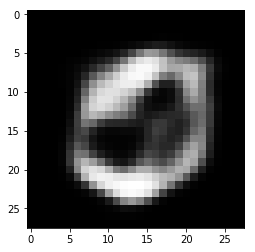

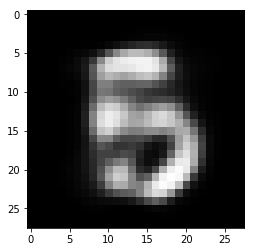

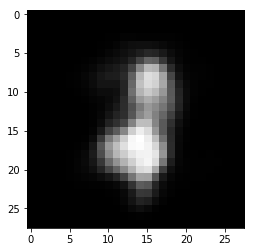

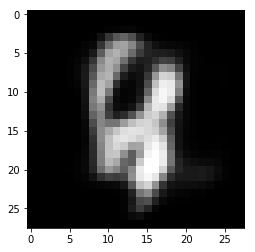

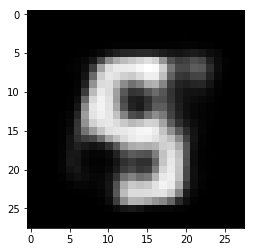

In [9]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    #plt.imshow(torch.squeeze(image[i]).numpy(),cmap='gray')
    #plt.show()
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

In [10]:
for i in range(1):
    for j,[image,label] in enumerate(test_loader):
       
        image = Variable(image,volatile=True).cuda()
        output,mean,var = encoder(image)
        output = decoder(output)
        
    if j % 10 == 0:
        print(loss)        

torch.Size([128, 28, 28])


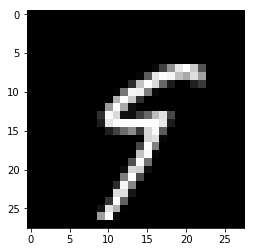

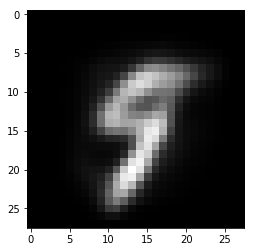

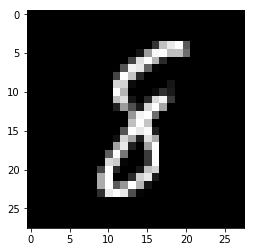

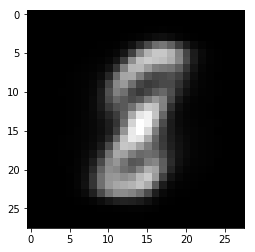

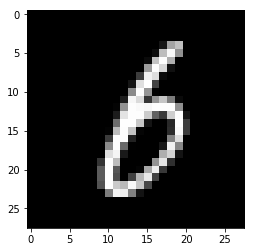

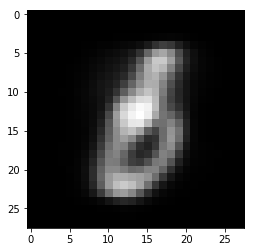

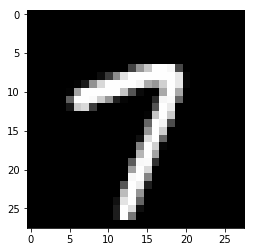

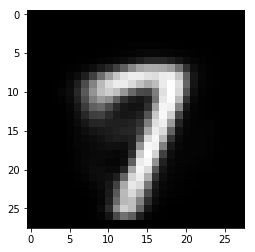

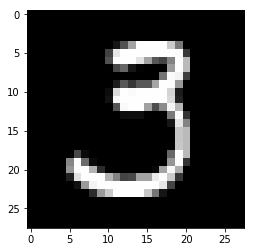

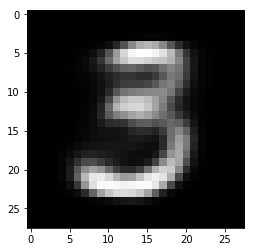

In [11]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.imshow(torch.squeeze(image[i].cpu()).data.numpy(),cmap='gray')
    plt.show()
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()